# Vodafone Challenge group X
## Comprehensive Notebook
This notebook includes most of the things we have tried, organized in a nice way. In the file VodafoneChallenge_Clustering file only the necessary parts are taken, based on what worked best on test sets here.
### Structure
1. Pipeline 
2. Issues Encountered
3. Discoveries
4. Code
    1. Imports
    2. Cleaning
    3. Imputation
    4. Weights Optimization
    5. Clustering

    

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

import graphviz
import time

import VodafoneChallenge_Classes

pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=np.NaN)

# Vodafone Challenge
## Scrap notebook
- **Separate each test** you make with a markdown cell like this one (press M when the cursor is on a cell but it is not editing). 
- Put a **small description** on what you are doing and why you do so (like if you manipulate data in a specific way, or apply a particular definition of distance, write the intuition behind. Both for you to remmember later and for team members)
- Make sure you are working with the **proper data** i.e. the data (and their transformation) that you with to use are defined before you do the analysis. Bugs could appear if you do not define something and Python retrieves older values for the variables you are using.
- **Do not modify df_backup**, always work with a copy [like df = df_backup.copy()]
- Add short line of description in the Summary section
- For each test, write briefly which value of the parameter tried (like learning rate constant, tried eta0 large (10^-2) not well, smaller (10^-7) seem to work best. Then changed with learning rate adaptivive [which?] and tried ... large (10^-2) worked best).

**For the best test, build pipeline: bulleted version of all things done on the dataset until the result. It could be a useful thing to do for each test actually**

## Summary

1. **K-means on traffic data**: tested for different k's, both standardized and not. Performs poorly.
2. **preprocessing zip-urb** (Abetone, Montoro, Ginosa, Capannori, Vigo di Fassa, Scarpiera e San Piero)
3. **Perc imputation**

## Code
### *setup*

In [305]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

import graphviz
import time

pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=np.NaN)

In [2]:
df_backup = pd.read_csv('dataset_challenge_v5.TRAINING.csv')

### Cleaning
**DeviceOperatingSystem**: I preferred not to create a specific category for 'windows' because too few observations, however, if the 'other' category reveals to explain well, we can unpack it (in a new dataset)

In [3]:
df_clean = df_backup.copy()

del df_clean['Unnamed: 0']

c = list(df_clean.columns)
c[0] = 'ID'
df_clean.columns = c

df_clean['ZipCode'] = df_clean['ZipCode'].map(lambda x: '%05i' % x, na_action='ignore')

traffic_columns = ['File-Transfer', 'Games',
       'Instant-Messaging-Applications', 'Mail', 'Music-Streaming',
       'Network-Operation', 'P2P-Applications', 'Security',
       'Streaming-Applications', 'Terminals', 'Unclassified', 'VoIP',
       'Web-Applications']
df_clean[traffic_columns]

cats = df_clean['CustomerAge'].astype('category').cat.categories
d = {cat:(15+10*i)/100 for i,cat in enumerate(cats)}
df_clean['NumericAge'] = df_clean['CustomerAge'].map(lambda x: d[x], na_action='ignore')

d = {}
for elem in df_clean['DeviceOperatingSystem']:
    d[elem] = d.get(elem, 0) + 1
print(d) #some categories have very few values, group them
OS_other = []
for key in d:
    if d[key] < 10:
        OS_other.append(key)
        d[key] = 'other'
    else:
        d[key] = key
df_clean['OS_clean'] = df_clean['DeviceOperatingSystem'].map(lambda x: d[x], na_action='ignore')

{'iOS': 568, nan: 548, 'Android': 858, 'Windows Mobile': 6, 'Proprietary': 5, 'Windows Phone': 7, 'BlackBerry OS': 1, 'Firefox': 1, 'Symbian^3': 1, 'BREW': 1, 'Series 40': 2, 'BB10': 1, 'VRTXmc': 1}


In [4]:
#Adding rural/urban information
df_zip_istat = pd.read_csv('databases/database.csv')
df_istat_urb = pd.read_csv('databases/it_postal_codes.csv/Foglio 2-Tabella 1.csv', error_bad_lines=False, sep = ';')
my_urb_dict = {'Basso' : 0, 'Medio' : 1, 'Elevato' : 2}
df_istat_urb['GradoUrbaniz'] = df_istat_urb['GradoUrbaniz'].map(lambda x: my_urb_dict[x], na_action = 'ignore')

#check there are no datapoint for which we don't have zip but we've region
df_clean['ZipCode'].isnull()
df_clean['Region'][df_clean['ZipCode'].isnull()]
len(df_clean['Region'][df_clean['ZipCode'].isnull()]) == np.sum(df_clean['Region'][df_clean['ZipCode'].isnull()].isnull())

#we need to insert x for multiple cap cities
isnan = lambda x: x != x
#nan is unique type not equal to itself, so with this lambda function we get True only when the type is NaN

for i in range(df_zip_istat.shape[0]):
    cap = df_zip_istat.loc[i, 'cap/0']
    cap  = '%05d' % cap
    if not isnan(df_zip_istat.loc[i,'cap/1']):
        if not isnan(df_zip_istat.loc[i,'cap/10']):   
            cap = cap[:-2]+'xx'
        else:
            cap = cap[:-1]+'x'
    df_zip_istat.loc[i, 'cap/0'] = cap

d_zip_istat = df_zip_istat.set_index('cap/0').to_dict()['codice']
d_istat_urb = df_istat_urb.set_index('ISTAT').to_dict()['GradoUrbaniz']

mask = df_clean['ZipCode'].isnull()
urban_col = np.zeros(df_clean.shape[0])
urban_col_masked = urban_col[~ mask]
d_zip_istat.update([('51021', 47023),( '83026', 64121),( '74025', 73007),( '55062', 46007),( '38039', 22217),('50037', 48053)])
d_istat_urb.update([(22250, 0),( 78157, 1)])

c = 0
for i in df_clean['ZipCode'][~ mask]:
    try:
        temp = d_zip_istat[i]
        urban_col_masked[c] = d_istat_urb[int(temp)]
    except KeyError:
        i = '%05d' % int(i)
        if i[:-1]+'x' in d_zip_istat:
            temp = d_zip_istat[i[:-1]+'x']
        elif i[:-2]+'xx' in d_zip_istat:
            temp = d_zip_istat[i[:-2]+'xx']
        else:
            raise()
    c += 1
    
df_clean['Urban'] = df_clean['ZipCode'].copy()
df_clean['Urban'][~ mask] = urban_col_masked

/Users/Renato/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Class definition and useful dependencies
Space that collects classes or function definition that come in handy throughtout the project

In [454]:
class buildTrain():
    def __init__(self, X, y, perc=(0.7,0.15,0.15), std=False, pca=0, seed=None, one_hot=False, cat_col=None):
        if seed is not None:
            np.random.seed(seed)
        n_data, n_features = X.shape
        if not isinstance(perc, tuple) or np.abs(1-sum(perc))>1e-7:
            raise Exception('Invalid value for perc', perc)
        if not isinstance(X, pd.DataFrame):
            raise Exception('must pass a pandas dataframe')
        assert n_data == len(y)
        
        dopca = pca is None or pca > 0
        origin_shape = X.shape
        
        #check and remove nan values
        X = X.copy()
        X[y.name] = y.copy()
        X.dropna(axis=0, how='any', inplace=True)
        
        if X.shape[0] < n_data:
            print('Warning: missing data found and removed. Old input shape: %d, %d, new input shape: %d, %d'
                  % (origin_shape[0], origin_shape[1]+1, *X.shape))
            y = X[y.name]
        X.drop(y.name, axis=1, inplace=True)
        n_data, _ = X.shape
    
        assert n_data == len(y)
        assert X.shape[1] == origin_shape[1]
        
        #do not perform OneHot if want to do PCA or std
        if dopca:
            one_hot = False
            
        if one_hot:
            if cat_col is None:
                cat_col = X.columns
            non_cat_col = [i for i in X.columns if i not in cat_col]
            for cat in cat_col:
                ret, columns = self._one_hot(X[cat])
                X.drop(cat, axis=1, inplace=True)
                for i in range(len(columns)):
                    X[columns[i]] = ret[:,i]
            self.X_one_hot = X.copy()
        
        perm = np.random.random(n_data)
        n_train = int(perc[0]*n_data)
        n_valid = int(perc[1]*n_data)
        train_mask = perm < perc[0]
        valid_mask = ~ train_mask.copy()
        valid_mask[~train_mask] = perm[~train_mask] < perc[0] + perc[1]
        test_mask = ~ np.logical_or(train_mask, valid_mask)
        
        train_data = X[train_mask]
        train_target = y[train_mask]
        valid_data = X[valid_mask]
        valid_target = y[valid_mask]
        test_data = X[test_mask]
        test_target = y[test_mask] 
        assert (len(train_data)+len(valid_data)+len(test_data)) == n_data
        
        if std:
            if not one_hot:
                mean = train_data.mean(axis=0)
                std = train_data.std(axis=0) + 1e-10
                train_data = (train_data - mean) / std
                valid_data = (valid_data - mean) / std
                test_data = (test_data - mean) / std
                print('Performed standardization')
            else:
                mean = train_data[non_cat_col].mean(axis=0)
                std = train_data[non_cat_col].std(axis=0) + 1e-10
                train_data[non_cat_col] = (train_data[non_cat_col] - mean) / std
                valid_data[non_cat_col] = (valid_data[non_cat_col] - mean) / std
                test_data[non_cat_col] = (test_data[non_cat_col] - mean) / std
                print('Performed standardization only on non-categorical columns')
        
        if dopca:
            my_pca = PCA(n_components=pca)
            my_pca.fit(train_data)
            train_data = my_pca.transform(train_data)
            valid_data = my_pca.transform(valid_data)
            test_data = my_pca.transform(test_data)
            print('performed PCA, number of features: %d, explained variance for component:\n'%(my_pca.n_components_), 
                  ['%.2f'%i for i in my_pca.explained_variance_])
        
        self.Xt = train_data
        self.yt = train_target
        self.Xv = valid_data
        self.yv = valid_target
        self.Xts = test_data
        self.yts = test_target
        
    def _one_hot(self, v):
        cats = np.unique(v)
        map_cat = {cat:i for i, cat in enumerate(cats)}
        map_cat_r = {map_cat[key]:key for key in map_cat}
        n_cat = len(cats)
        n_rows = len(v)
        ret = np.zeros((n_rows,n_cat))
        for i in range(n_rows):
            ret[i, map_cat[v[i]]] = 1
        columns = ['%s_%s' % (v.name, map_cat_r[i]) for i in range(n_cat)]
        return ret, columns
                              
        
    def get_train(self):
        return self.Xt, self.yt
    
    def get_valid(self):
        return self.Xv, self.yv
    
    def get_test(self):
        return self.Xts, self.yts
    
    def get_size(self):
        return self.Xt.shape, self.Xv.shape, self.Xts.shape
    
    def get_one_hot(self):
        return self.X_one_hot

In [6]:
class logger():
    def __init__(self, verbose = True):
        self.v = verbose
        self.log_ = []
        
    def log_it(self, text):
        #adds to log record
        if not isinstance(text, str):
            raise Exception('must pass text to logger')
        if self.v:
            print(text)
        self.log_.append(text)
        
    def print_out(self, text):
        if not isinstance(text, str):
            raise Exception('must pass text to logger')
        #doesn't add to log record
        if self.v:
            print(text)
        
    def show_img(self, array):
        if not isinstance(array, np.ndarray):
            raise Exception(1)
        if self.v:
            plt.imshow(array)
        
    def get_log(self):
        return "\n".join(self.log_)

In [463]:
def check_clusters(y, clust_labels, img_threshold=15, v=True):
    #checks input
    if y.ndim != 1: 
        raise Exception(2)
    if len(y) != len(clust_labels):
        raise Exception(4)
    
    #logger setup
    my_log = logger(verbose=v)
        
    #build histogram of categories (how many point for each cat)
    cats = {}
    for i in y:
        cats[i] = cats.get(i, 0) + 1
    n_cats = len(cats)
    
    #build histogram of clusters (how many point in each cluster)
    clusters = {}
    for i in clust_labels:
        clusters[i] = clusters.get(i, 0) + 1
    n_clusters = len(clusters)
        
    #create mapping from categories to index (to easily store data)
    #done because we assume y's values can be different from range(n_categories)
    #cat_list useful to quickly go back (header of result matrix)
    cat_map = {}
    cat_list = []
    for i, cat in enumerate(cats):
        cat_map[cat] = i
        cat_list.append(cat)
    
    #for each cluster, computes proportion of point belonging to each category
    result = np.zeros((n_clusters, n_cats))
    tot_per_clust = np.zeros((n_clusters,1), dtype=int)
    for i, clust in enumerate(clusters):
        labels = y[clust_labels == clust]
        tot_per_clust[i] = clusters[clust]
        for cat in labels:
            result[i,cat_map[cat]] += 1
            
    #to compute percentage of category points
    perc_cat = []
    for clust in range(len(result)):
        i_max = np.argmax(result[clust,:])
        tot = cats[cat_list[i_max]]
        perc_cat.append(result[clust, i_max] / tot * 100)
        
    #express each value as a proportion (normalization)
    result = result / tot_per_clust * 100
    
    #show graphical representation if matrix not too big
    if n_cats < img_threshold and n_clusters < img_threshold:
        my_log.show_img(result)
        
    #for each cluster show the category that fits it best
    for i,value in enumerate(np.argmax(result, axis=1)):
        #frequency of category: number of datapoint of a specific category belonging to that cluster
        #over the number of points in the cluster (variety within cluster)
        #category clustering: number of datapoint of a specific category belonging to that cluster,
        #over the total number of points of that category
        my_log.log_it('\ncluster: %s'% i)
        my_log.log_it('--> top category: %s, frequency of category (variety within cluster): %.2f%%, category clustering: %.2f%%'\
                     % (cat_list[value], result[i, value], perc_cat[i]))
        #print("tot per clust:", int(tot_per_clust[i]), "type:", type(np.float(tot_per_clust[i])), "len(y):", len(y), "type:",type(len(y)))
        temp = len(y)
        to_be_logged = ((int(tot_per_clust[i]))/temp)*100
        my_log.log_it('Cluster size: %.2f%%' % to_be_logged)
        to_be_logged = str({cat_list[i]:col for i,col in enumerate(result[i,:])})
        my_log.log_it('--> histogram: %s' % to_be_logged)
    score = np.sum(np.max(result, axis=1))/n_clusters
    weighted = np.dot(np.max(result, axis=1), np.array(perc_cat))/100
    #maybe it's best to weight the score by the category clustering index (see k-means example below)
    my_log.log_it("Overall score (doesn't consider category clustering): %.2f%%, weighted: %.2f%%"%(score, weighted))
    return weighted, my_log.get_log()

In [8]:
def standardize(df, column):
    if not isinstance(column, (str, int)):
        raise Exception(1)
    #returns a copy of the standardized column
    c = df[column].copy()
    mean = c.mean()
    sd = c.std()
    return (c - mean) / sd

In [9]:
def batch_std(df, columns):
    if not isinstance(columns, str):
        if len(columns) == 0:
            raise Exception('nto enough columns')
    else:
        raise Exception('must be an array or list')
    #returns a new dataframe with standardized columns
    new_df = pd.DataFrame()
    for column in columns:
        temp = standardize(df, column)
        new_df[column] = temp
    return new_df

In [10]:
class test():
    def __init__(self):
        self.best = [0,0,0]
        self.scores = []
        
    def update(self, score, k):
        score, log = score
        if score > self.best[0]:
            self.best = score, k, log
        self.scores.append((k, score))
        
    def get_result(self):
        best = self.best
        scores = self.scores
        print('best weighted score: %.2f%%, number of clusters: %i' % (best[0], best[1]))
        print('log of best: \n%s' % best[2])
        plt.figure()
        plt.plot(*zip(*scores),'-')

In [520]:
class interface():
    def __init__(self, seed = None, build_seed = None, data=None):
        if seed is None:
            seed = np.random.randint(666766)
        self.seed = seed
        self.build_seed = build_seed
        self.data = data
            
    def train(self, X, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, epochs=30, **args):
        np.random.seed(self.seed)
        data = self.data
        if data is None:
            data = buildTrain(X, y, percentage, std, pca, seed=self.build_seed)
        self._check_balanced(data.get_train()[1], threshold_unbalanced, args)
        train_param = (X, y, data, epochs, args)
        self._train(*train_param)
        if self.unbalanced:
            self._unbal_output(data.get_valid())
        self.data = data
        self.train_param = train_param
            
    def _check_balanced(self, y, threshold_unbalanced, args):
        unbalanced = False
        
        #check unbalanced dataset
        d_cat = {}
        clean_y = y[~y.isnull()]
        for i in clean_y:
            d_cat[i] = d_cat.get(i, 0) + 1
        max_cat = 0
        max_num = 0
        for cat in d_cat:
            if d_cat[cat] > max_num:
                max_cat = cat
                max_num = d_cat[cat] 
        if max_num / len(clean_y) > threshold_unbalanced:
            print('Warning: found unbalanced dataset, training using balanced setting for class_weight')
            if 'class_weight' in args and args['class_weight'] is None:
                class_weight = {cat: 1/(d_cat[cat]/len(clean_y)) for cat in d_cat}
                args['class_weight'] = class_weight
                print('Weights used:', {i:float('%.2f'%class_weight[i]) for i in class_weight})
            unbalanced = True
        self.unbalanced = unbalanced
        
    def _train(self, X, y, data, epochs, args):
        raise Exception('not implemented')
            
    def _unbal_output(self, valid):
        Xv, yv = valid
        obj = self.obj
        d_cat = {}
        for i in yv:
            d_cat[i] = d_cat.get(i, 0) + 1
        max_cat = 0
        max_num = 0
        for cat in d_cat:
            if d_cat[cat] > max_num:
                max_cat = cat
                max_num = d_cat[cat]
        mask = yv != max_cat
        if np.sum(mask) == 0:
            raise Exception('No data in smaller part of valid set')
        minority_score = obj.score(Xv[mask], yv[mask])
        majority_score = obj.score(Xv[~mask], yv[~mask])
        print('Score on smaller part (%.2f%%) of validation set (unbalanced case): %.2f' % 
              (np.sum(mask)/len(yv)*100, minority_score))
        print('Score on bigger part (%.2f%%) of validation set (unbalanced case): %.2f' % 
              (np.sum(~mask)/len(yv)*100, majority_score))
        print('Category histogram in validation set:', d_cat)
            
   
        
    def test(self, n=10):
        best = np.zeros(n)
        worse = np.zeros(n)
        for i in range(n):
            np.random.seed(np.random.randint(10001)*i)
            tscores, vscores,_ = self._train(self.train_param)
            best[i] = np.max(vscores)
            worse[i] = np.min(vscores)
        print('average best performance: %.2f%%, standard deviation: %f'%(best.mean(), best.std()))
        plt.figure()
        plt.plot(np.arange(n), worse, color='r', label='worse performances')
        plt.plot(np.arange(n), best, color='g', label='best performances')
        legend = plt.legend(loc='upper center', shadow=True)
        plt.xlabel('samples')
        plt.ylabel('test score')
        plt.show()
        
    def predict(self, X, y, fill_up=False):
        obj = self.obj
        assert y.shape[0] == X.shape[0]
        mask = y.isnull()
        to_be_predicted = X[mask]
        assert to_be_predicted.shape[0] != 0
        prediction = obj.predict(to_be_predicted)
        if fill_up:
            y[mask] = prediction
        return prediction
    
    def get_test(self):
        return self.data.get_test()

In [521]:
def train_perc_warm(perc, data, X, y, epochs, eta0, f_eta, v):
    
    n_features = data.get_train()[0].shape[1]
    n_classes = len(data.get_train()[1].unique())
    
    if n_classes == 1:
        raise Exception(1)
    if n_classes == 2:
        n_classes = 1
        
    coef = np.random.randn(n_classes, n_features) * 1e-2
    intercept = np.random.randn(n_classes) * 1e-2
    eta = eta0
    
    tscores = []
    vscores = []
    for epoch in range(epochs):
        perc.set_params(eta0=eta)
        perc.fit(*data.get_train(), coef_init = coef, intercept_init = intercept)
        tscore = perc.score(*data.get_train())
        vscore = perc.score(*data.get_valid())
        if v:
            print("run=%i tscore=%g vscore=%g" % (epoch+1, tscore, vscore))
        tscores.append(tscore)
        vscores.append(vscore)
        coef, intercept = perc.coef_, perc.intercept_
        eta = f_eta(eta0, epoch)
    if v:
        plt.figure()
        plt.plot(np.arange(epochs), tscores, np.arange(epochs), vscores)
        
    return tscores, vscores

In [522]:
def train_perc_cold(perc, data, X, y, max_iter):
    
    perc.set_params(max_iter=max_iter)
    perc.fit(*data.get_train())
    tscore = perc.score(*data.get_train())
    vscore = perc.score(*data.get_valid())
    print("tscore=%g vscore=%g" % (tscore, vscore))
        
    return tscore, vscore

In [523]:
class perc(interface):
    
    def _train(self, X, y, data, epochs, args):
        warm_start = True
        learning_rate = args.get('learning_rate', 'optimal')
        it_interval = args.pop('it_interval', 100)
        power_t = args.get('power_t', 0.5)
        #check learning_rate
        if learning_rate == 'constant':
            f_eta = lambda eta0, epoch: eta0
        elif learning_rate == 'invscaling':
            f_eta = lambda eta0, epoch: eta0 / ((epoch + 1) * it_interval)**power_t
        elif learning_rate == 'optimal':
            warm_start = False
            f_eta = None
        else:
            raise Exception('not valid value')                
            
        #compute max_iter
        max_iter = epochs * it_interval
        args['max_iter'] = it_interval
            
        #create multiple perceptron
        perc_ = SGDClassifier(**args)

        param_warm = (perc_, data, X, y, epochs, args['eta0'], f_eta, True)
        param_cold = (perc_, data, X, y, max_iter)
        
        #perform analysis
        if warm_start:
            tscores, vscores = train_perc_warm(*param_warm)
        else:
            tscores, vscores = train_perc_cold(*param_cold)
            
        self.obj = perc_
        return tscores, vscores
    
    def __str__(self):
        return 'Perceptron interface'

In [524]:
def train_MLP(ml_perc, data, X, y, max_iter= 30, v=True):
    
    tscores = []
    vscores = []
    for epoch in range(max_iter):
        ml_perc.set_params(max_iter=epoch+1)
        ml_perc.fit(*data.get_train())
        tscore = ml_perc.score(*data.get_train())
        vscore = ml_perc.score(*data.get_valid())
        loss = ml_perc.loss_
        if v:
            print(f"epoch={epoch} loss={loss} tscore={tscore} vscore={vscore}")
        tscores.append(tscore)
        vscores.append(vscore)
        ml_perc.set_params(warm_start=True)
        
    if v:
        plt.figure()
        plt.plot(np.arange(max_iter), tscores, np.arange(max_iter), vscores)
    
    return tscores, vscores

In [525]:
class MLP(interface):
    
    def _train(self, X, y, data, epochs, args):             
            
        #create multiple perceptron
        ml_perc_ = MLPClassifier(**args)
        
        param_warm = (ml_perc_, data, X, y, epochs, True)
        
        tscores, vscores = train_MLP(*param_warm)
        
        #save settings
        self.obj = ml_perc_
        return tscores, vscores
    
    def __str__(self):
        return 'MLP interface'

In [526]:
def train_LR(log_reg, data, X, y, max_iter= 30, v=True):

    tscores = []
    vscores = []
    for epoch in range(max_iter):
        log_reg.set_params(max_iter=epoch+1)
        log_reg.fit(*data.get_train())
        tscore = log_reg.score(*data.get_train())
        vscore = log_reg.score(*data.get_valid())
        if v:
            print(f"epoch={epoch} tscore={tscore} vscore={vscore}")
        tscores.append(tscore)
        vscores.append(vscore)
        log_reg.set_params(warm_start=True)
        
    if v:
        plt.figure()
        plt.plot(np.arange(max_iter), tscores, np.arange(max_iter), vscores)
    
    return tscores, vscores

In [527]:
class LogReg(interface):
    
    #penalty=’l2’, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
    #class_weight=None, random_state=None, solver=’liblinear’, max_iter=100, multi_class=’ovr’, 
    #verbose=0, warm_start=False, n_jobs=1
    #solver : {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’},
    #default: ‘liblinear’ Algorithm to use in the optimization problem.
    #For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones.
    #For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’
    #handle multinomial loss; ‘liblinear’ is limited to one-versus-rest schemes.
    #‘newton-cg’, ‘lbfgs’ and ‘sag’ only handle L2 penalty, whereas ‘liblinear’ and ‘saga’ handle L1 penalty.
    
    #Multiclass option can be either ‘ovr’ or ‘multinomial’. If the option chosen is ‘ovr’, then a binary problem 
    #is fit for each label. Else the loss minimised is the multinomial loss fit across the entire probability distribution. 
    #Does not work for liblinear solver.

         
    def _train(self, X, y, data, epochs, args):            
        
        #create logistic regression
        log_regr_ = LogisticRegression(**args)
        
        param_warm = (log_regr_, data, X, y, epochs, True)
        
        tscores, vscores = train_LR(*param_warm)
        
        #save settings
        self.obj = log_regr_
        return tscores, vscores
    def __str__(self):
        return 'Logistic Regression interface'

In [528]:
def train_trees(tree, data, X, y):
    
    tree.fit(*data.get_train())
    tscore = tree.score(*data.get_train())
    vscore = tree.score(*data.get_valid())
    print("tscore=%g vscore=%g" % (tscore, vscore))
        
    return tscore, vscore

In [533]:
class trees(interface):
    
    def train(self, X, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, tree_type='RF', **args):
        np.random.seed(self.seed)
        data = self.data
        if data is None:
            data = buildTrain(X, y, percentage, std, pca, seed=self.build_seed)
        self._check_balanced(data.get_train()[1], threshold_unbalanced, args)
        train_param = (X, y, data, tree_type, args)
        self._train(*train_param)
        if self.unbalanced:
            self._unbal_output(data.get_valid())
        self.data = data
        self.tree_type = tree_type
        self.train_param = train_param
        
    def _train(self, X, y, data, tree_type, args):
        if tree_type == 'RF':
            tree_ = RandomForestClassifier(**args)
        elif tree_type == 'DT':
            tree_ = tree.DecisionTreeClassifier(**args)
        elif tree_type == 'XRF':
            tree_ = ExtraTreesClassifier(**args)
        else:
            raise Exception(1)
            
        param_warm = (tree_, data, X, y)
        tscores, vscores = train_trees(*param_warm)
        
        #save settings
        self.obj = tree_
        return tscores, vscores
    
    def view_tree(self, **args):
        if self.tree_type == 'DT':
            dot_data = tree.export_graphviz(self.obj, out_file=None,
                             filled=True, rounded=True, special_characters=True, **args)
            graph = graphviz.Source(dot_data)  
            graph.view()
        else:
            print("Can't show tree for this model")
        
    def __str__(self):
        tree_type = self.tree_type
        if tree_type == 'RF':
            return 'Random Forest Interface'
        elif tree_type == 'DT':
            return 'Decision Tree Interface'
        elif tree_type == 'XRF':
            return 'Extremely Randomized Trees Interface'
        else:
            raise Exception(1)

In [530]:
def test_sup(*objs):
    scores = np.zeros(len(objs))
    c = 0
    plt.figure()
    for obj in objs:
        X, y = obj.data.get_test()
        if not isinstance(obj, interface):
            raise Exception('must pass interface subclass object')
        print(X.shape, y.shape)
        score = obj.obj.score(X, y)
        print(score)
        scores[c] = score
        print(scores)
        c += 1
        print(c)
        plt.plot(c, score, '.', label=str(obj))
    legend = plt.legend(loc=(1.01, 0), shadow=True)
    plt.show()
    i_max = np.argmax(scores)
    print('best is %s with score %.2f' % (str(objs[i_max]), scores[i_max]))
    return objs[i_max]

## Questions
1. How can we decide which approach to prefer between substituting with the mean of the column and using a trained supervised (with a certain accuracy), in the case of missing values?
2. How do we optimize parameters in unbalanced dataset? Because for us we can go over 50% on big and small dataset
4. What can we do if dataset unbalanced and we are using MLP?

## Next Steps
1. Train MLP (build interface if needed, should be needed)
2. Predict age wrt traffic data for filling in the data
3. Predict os wrt traffic data for filling in the data
4. Predict urbaniz wrt traffic data for filling in the data
5. Predict data allowance wrt traffic data for filling in the data
6. Monthly data traffic
7. others
8. clusteringggg

## Data imputation taken seriously
### OS

In [422]:
df_filled = df_clean.copy()
percentage_used = (0.70,0.15,0.15)
X = df_filled[traffic_columns]
y = df_filled['OS_clean']
build_seed = 456245
my_perc = perc(build_seed)
my_MLP = MLP(build_seed)
my_lr = LogReg(build_seed)
my_forest = trees(build_seed)

(1452, 14)
performed PCA, number of features: 4, explained variance for component:
 ['0.07', '0.02', '0.01', '0.00']
run=1 tscore=0.373506 vscore=0.400922
run=2 tscore=0.373506 vscore=0.400922
run=3 tscore=0.373506 vscore=0.400922
run=4 tscore=0.373506 vscore=0.400922
run=5 tscore=0.373506 vscore=0.400922
run=6 tscore=0.373506 vscore=0.400922
run=7 tscore=0.373506 vscore=0.400922
run=8 tscore=0.373506 vscore=0.400922
run=9 tscore=0.373506 vscore=0.400922
run=10 tscore=0.373506 vscore=0.400922
run=11 tscore=0.373506 vscore=0.400922
run=12 tscore=0.373506 vscore=0.400922
run=13 tscore=0.373506 vscore=0.400922
run=14 tscore=0.373506 vscore=0.400922
run=15 tscore=0.373506 vscore=0.400922
run=16 tscore=0.373506 vscore=0.400922
run=17 tscore=0.373506 vscore=0.400922
run=18 tscore=0.373506 vscore=0.400922
run=19 tscore=0.373506 vscore=0.400922
run=20 tscore=0.373506 vscore=0.400922
run=21 tscore=0.373506 vscore=0.400922
run=22 tscore=0.373506 vscore=0.400922
run=23 tscore=0.373506 vscore=0.40

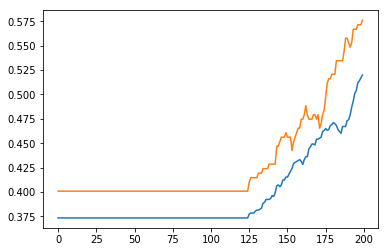

In [423]:
my_perc.train(X, y, percentage=percentage_used, std=False, pca=0.9, threshold_unbalanced=0.6, epochs=200,  loss='log', 
              penalty='none', alpha=1e-8, power_t=0.5, it_interval=100, learning_rate='constant', eta0=1e-8,
              class_weight={'Android': 1.65, 'iOS': 2.70, 'other': 50.2})

epoch=0 loss=0.8832857293186401 tscore=0.6165338645418327 vscore=0.5898617511520737
epoch=1 loss=0.7495404073508319 tscore=0.6105577689243028 vscore=0.5852534562211982
epoch=2 loss=0.7675696718069235 tscore=0.6444223107569721 vscore=0.6405529953917051
epoch=3 loss=0.7321316519543257 tscore=0.6205179282868526 vscore=0.5990783410138248
epoch=4 loss=0.7108590891655031 tscore=0.6852589641434262 vscore=0.6774193548387096
epoch=5 loss=0.7120464942454815 tscore=0.6284860557768924 vscore=0.6175115207373272
epoch=6 loss=0.7010195591572481 tscore=0.6404382470119522 vscore=0.631336405529954
epoch=7 loss=0.6947629988104134 tscore=0.6743027888446215 vscore=0.6774193548387096
epoch=8 loss=0.6866469980665065 tscore=0.7151394422310757 vscore=0.7004608294930875
epoch=9 loss=0.6732674292448274 tscore=0.6454183266932271 vscore=0.6359447004608295
epoch=10 loss=0.6723087291714355 tscore=0.6643426294820717 vscore=0.6543778801843319


/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


epoch=11 loss=0.6603240371245978 tscore=0.7679282868525896 vscore=0.7603686635944701
epoch=12 loss=0.6781651824098722 tscore=0.6424302788844621 vscore=0.6405529953917051
epoch=13 loss=0.6691259819230907 tscore=0.6553784860557769 vscore=0.6451612903225806
epoch=14 loss=0.6730638921191016 tscore=0.7828685258964143 vscore=0.783410138248848
epoch=15 loss=0.6572876431793208 tscore=0.7061752988047809 vscore=0.6912442396313364
epoch=16 loss=0.6472322731816698 tscore=0.6424302788844621 vscore=0.6497695852534562
epoch=17 loss=0.6630155541278525 tscore=0.7300796812749004 vscore=0.7373271889400922
epoch=18 loss=0.640287048172193 tscore=0.6862549800796812 vscore=0.6589861751152074
epoch=19 loss=0.6288780237933157 tscore=0.7241035856573705 vscore=0.7142857142857143
epoch=20 loss=0.6132176979037867 tscore=0.7440239043824701 vscore=0.7511520737327189
epoch=21 loss=0.6050637424297189 tscore=0.7330677290836654 vscore=0.7188940092165899
epoch=22 loss=0.6012915439991406 tscore=0.7051792828685259 vscore=0

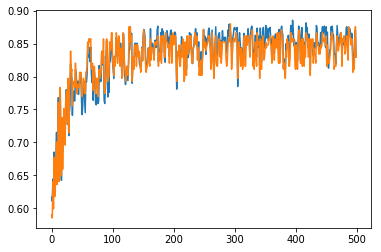

In [24]:
my_MLP.train(X, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, epochs=500,
             hidden_layer_sizes = (200,), batch_size = 100, learning_rate_init=1e-2, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 0.01, tol = 1e-4)

performed PCA, number of features: 4, explained variance for component:
 ['0.63', '0.18', '0.07', '0.03']
Weights used: {'Android': 1.65, 'iOS': 2.68, 'other': 50.2}
epoch=0 tscore=0.3555776892430279 vscore=0.34101382488479265
epoch=1 tscore=0.4033864541832669 vscore=0.41013824884792627
epoch=2 tscore=0.41334661354581675 vscore=0.43317972350230416
epoch=3 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=4 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=5 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=6 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=7 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=8 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=9 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=10 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=11 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=12 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=13 tscore=0.414342629

/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


epoch=26 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=27 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=28 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=29 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=30 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=31 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=32 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=33 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=34 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=35 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=36 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=37 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=38 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=39 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=40 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=41 tscore=0.41434262948207173 vscore=0.4331797235

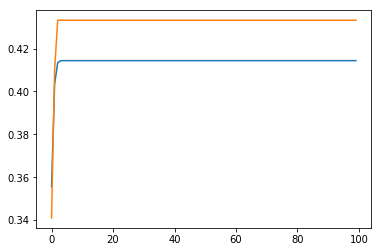

In [25]:
my_lr.train(X, y, percentage=(0.70,0.15,0.15), std=False, pca=0.9, threshold_unbalanced=0.6, epochs=100,
            penalty="l2", dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
            class_weight=None,  solver="newton-cg", max_iter=100, multi_class="multinomial")

In [26]:
my_forest.train(X, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, tree_type='XRF',
                n_estimators = 50, max_features = "auto", criterion = "entropy", max_depth = 15,
                min_samples_split = 50, n_jobs = -1)

tscore=0.910359 vscore=0.917051
Score on smaller part (41.47%) of validation set (unbalanced case): 0.82
Score on bigger part (58.53%) of validation set (unbalanced case): 0.98
Category histogram in validation set: {'iOS': 87, 'Android': 127, 'other': 3}


(231, 13) (231,)
0.9047619047619048
[0.9047619 0.        0.        0.       ]
1
(231, 4) (231,)
0.43722943722943725
[0.9047619  0.43722944 0.         0.        ]
2
(231, 13) (231,)
0.8225108225108225
[0.9047619  0.43722944 0.82251082 0.        ]
3
(231, 4) (231,)
0.46320346320346323
[0.9047619  0.43722944 0.82251082 0.46320346]
4


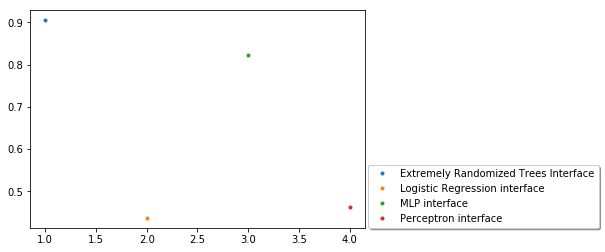

best is Extremely Randomized Trees Interface with score 0.90


In [27]:
best = test_sup(my_forest, my_lr, my_MLP, my_perc)

Therefore we use this XRT to predict the rest of the column OS and keep the predictions to imput into our dataset later.

In [28]:
os_missing = best.predict(X,y, fill_up=True)

/Users/Renato/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Urbanization

In [424]:
X = df_filled[traffic_columns]
df_filled['Urban'] = df_filled['Urban'].map(lambda x: int(x), na_action = 'ignore')
y = df_filled['Urban']
build_seed = 4562
my_perc = perc(build_seed)
my_MLP = MLP(build_seed)
my_lr = LogReg(build_seed)

(1654, 14)
run=1 tscore=0.335972 vscore=0.32549
run=2 tscore=0.335972 vscore=0.32549
run=3 tscore=0.335972 vscore=0.32549
run=4 tscore=0.336851 vscore=0.32549
run=5 tscore=0.336851 vscore=0.32549
run=6 tscore=0.335972 vscore=0.32549
run=7 tscore=0.336851 vscore=0.32549
run=8 tscore=0.336851 vscore=0.32549
run=9 tscore=0.336851 vscore=0.32549
run=10 tscore=0.337731 vscore=0.32549
run=11 tscore=0.337731 vscore=0.32549
run=12 tscore=0.337731 vscore=0.32549
run=13 tscore=0.33861 vscore=0.32549
run=14 tscore=0.33861 vscore=0.32549
run=15 tscore=0.33861 vscore=0.32549
run=16 tscore=0.33861 vscore=0.32549
run=17 tscore=0.33861 vscore=0.32549
run=18 tscore=0.337731 vscore=0.32549
run=19 tscore=0.337731 vscore=0.32549
run=20 tscore=0.337731 vscore=0.32549
run=21 tscore=0.337731 vscore=0.321569
run=22 tscore=0.337731 vscore=0.321569
run=23 tscore=0.33861 vscore=0.321569
run=24 tscore=0.337731 vscore=0.321569
run=25 tscore=0.337731 vscore=0.32549
run=26 tscore=0.336851 vscore=0.32549
run=27 tscor

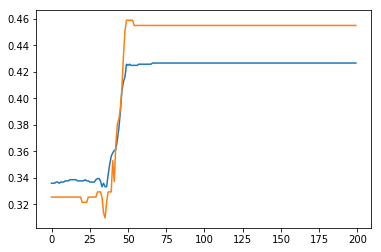

In [425]:
my_perc.train(X, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, epochs=200,  loss='squared_hinge', 
              penalty='none', alpha=1e-8, power_t=0.7, it_interval=100, learning_rate='constant', eta0=1e-8,
              class_weight=None)

epoch=0 loss=1.1388561402064168 tscore=0.3254177660510114 vscore=0.32941176470588235
epoch=1 loss=1.129611403196347 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=2 loss=1.1221763604039303 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=3 loss=1.1161255771344782 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=4 loss=1.1112807545489278 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=5 loss=1.1071973172368235 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=6 loss=1.1039714665865776 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=7 loss=1.1012979054668546 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=8 loss=1.0990477923642585 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=9 loss=1.0973390164968386 tscore=0.42656112576956906 vscore=0.4549019607843137


/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


epoch=10 loss=1.09581602890517 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=11 loss=1.0945314937503479 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=12 loss=1.093327346540357 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=13 loss=1.0924357605387214 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=14 loss=1.091637634224572 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=15 loss=1.0908057064253434 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=16 loss=1.0900874559683187 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=17 loss=1.089414246874098 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=18 loss=1.0888159345258999 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=19 loss=1.0882189886146851 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=20 loss=1.087795471766337 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=21 loss=1.0871541667819626 tscore=0.42656112576956906 

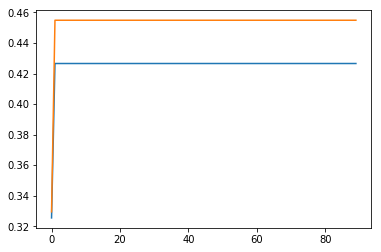

In [31]:
my_MLP.train(X, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, epochs=90,
             hidden_layer_sizes = (200,), batch_size = 50, learning_rate_init=1e-4, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 0.10, tol = 1e-4)

epoch=0 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=1 tscore=0.4212840809146878 vscore=0.47058823529411764
epoch=2 tscore=0.43007915567282323 vscore=0.4627450980392157
epoch=3 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=4 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=5 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=6 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=7 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=8 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=9 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=10 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=11 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=12 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=13 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=14 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=15 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=16 tscore=0.4309586631486

/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


epoch=52 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=53 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=54 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=55 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=56 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=57 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=58 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=59 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=60 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=61 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=62 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=63 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=64 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=65 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=66 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=67 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=68 tscore=0.430958

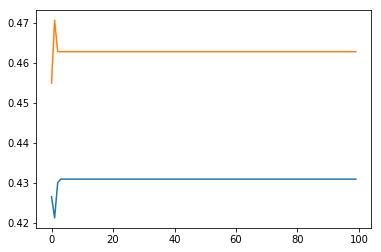

In [32]:
my_lr.train(X, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, epochs=100,
            penalty="l2", dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
            class_weight=None,  solver="newton-cg", max_iter=100, multi_class="multinomial")

In [33]:
my_forest.train(X, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, tree_type='XRF',
                n_estimators = 50, max_features = "auto", criterion = "entropy", max_depth = 15,
                min_samples_split = 50, n_jobs = -1)

tscore=0.509123 vscore=0.408


(253, 13) (253,)
0.4308300395256917
[0.43083004 0.         0.         0.        ]
1
(262, 13) (262,)
0.4389312977099237
[0.43083004 0.4389313  0.         0.        ]
2
(262, 13) (262,)
0.45038167938931295
[0.43083004 0.4389313  0.45038168 0.        ]
3
(262, 13) (262,)
0.45038167938931295
[0.43083004 0.4389313  0.45038168 0.45038168]
4


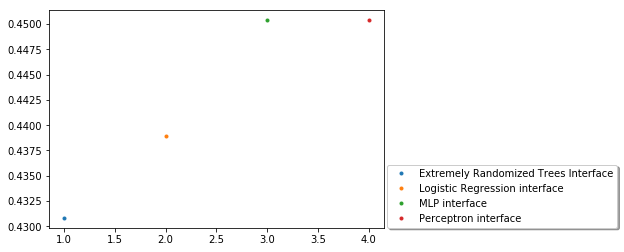

best is MLP interface with score 0.45


In [34]:
best = test_sup(my_forest, my_lr, my_MLP, my_perc)

In [35]:
urbanization = best.predict(X,y, fill_up=True)

/Users/Renato/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Numeric Age

In [36]:
dict_numage_to_agecat = {0.85: 2, 0.65: 1, 0.35: 0, 0.75: 1, 0.55: 1, 0.45: 1, 0.25: 0, 0.15: 0}
df_filled["NumericAge"] = df_filled["NumericAge"].map(lambda x: dict_numage_to_agecat[x], na_action = 'ignore')
X = df_filled[traffic_columns]
y = df_filled['NumericAge']
build_seed = 456222
my_perc = perc(build_seed)
my_MLP = MLP(build_seed)
my_lr = LogReg(build_seed)

run=1 tscore=0.649579 vscore=0.589474
run=2 tscore=0.636572 vscore=0.6
run=3 tscore=0.620505 vscore=0.575439
run=4 tscore=0.617445 vscore=0.561404
run=5 tscore=0.617445 vscore=0.561404
run=6 tscore=0.605968 vscore=0.561404
run=7 tscore=0.607498 vscore=0.568421
run=8 tscore=0.605968 vscore=0.582456
run=9 tscore=0.602142 vscore=0.582456
run=10 tscore=0.600612 vscore=0.585965
run=11 tscore=0.603673 vscore=0.6
run=12 tscore=0.604438 vscore=0.592982
run=13 tscore=0.606733 vscore=0.592982
run=14 tscore=0.605203 vscore=0.6
run=15 tscore=0.605203 vscore=0.603509
run=16 tscore=0.604438 vscore=0.6
run=17 tscore=0.609028 vscore=0.596491
run=18 tscore=0.609793 vscore=0.589474
run=19 tscore=0.611324 vscore=0.6
run=20 tscore=0.608263 vscore=0.6
run=21 tscore=0.604438 vscore=0.592982
run=22 tscore=0.604438 vscore=0.585965
run=23 tscore=0.604438 vscore=0.585965
run=24 tscore=0.600612 vscore=0.578947
run=25 tscore=0.595256 vscore=0.585965
run=26 tscore=0.598317 vscore=0.585965
run=27 tscore=0.597552 vs

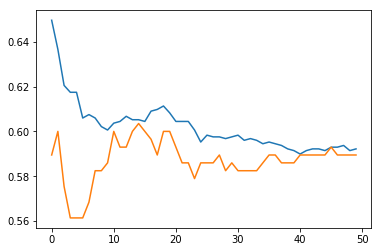

In [37]:
my_perc.train(X, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, epochs=50,  
              loss='log', penalty='none', alpha=1e-8, power_t=0.7, it_interval=100, learning_rate='constant', 
              eta0=1e-4, class_weight={2.0: 261.4, 1.0: 1.54, 0.0: 4.20})

epoch=0 loss=0.807371477777275 tscore=0.6472838561591431 vscore=0.6
epoch=1 loss=0.6778907706063428 tscore=0.6472838561591431 vscore=0.6
epoch=2 loss=0.6960129401814067 tscore=0.648814078041316 vscore=0.6035087719298246
epoch=3 loss=0.67631331763764 tscore=0.6541698546289212 vscore=0.6070175438596491
epoch=4 loss=0.672543859061838 tscore=0.6480489671002295 vscore=0.6
epoch=5 loss=0.669702337487172 tscore=0.6480489671002295 vscore=0.6
epoch=6 loss=0.6691233319097804 tscore=0.5554705432287682 vscore=0.5508771929824562
epoch=7 loss=0.6943121409231472 tscore=0.6480489671002295 vscore=0.6
epoch=8 loss=0.6726161705192022 tscore=0.6480489671002295 vscore=0.6
epoch=9 loss=0.6745267727800957 tscore=0.6273909716908952 vscore=0.5684210526315789
epoch=10 loss=0.6918967104751332 tscore=0.6480489671002295 vscore=0.6


/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


epoch=11 loss=0.6693856659597254 tscore=0.6480489671002295 vscore=0.5929824561403508
epoch=12 loss=0.665885570519515 tscore=0.6480489671002295 vscore=0.6
epoch=13 loss=0.6642739023491268 tscore=0.6480489671002295 vscore=0.6
epoch=14 loss=0.6593350134498989 tscore=0.6495791889824024 vscore=0.6035087719298246
epoch=15 loss=0.6599268638462826 tscore=0.6480489671002295 vscore=0.6
epoch=16 loss=0.6733208742719036 tscore=0.6373374139250191 vscore=0.5964912280701754
epoch=17 loss=0.6691253601563862 tscore=0.6480489671002295 vscore=0.6
epoch=18 loss=0.664153733866062 tscore=0.6518745218056619 vscore=0.6070175438596491
epoch=19 loss=0.6601251918138836 tscore=0.6480489671002295 vscore=0.6
epoch=20 loss=0.6582700221821541 tscore=0.6480489671002295 vscore=0.6
epoch=21 loss=0.6615872358113616 tscore=0.6480489671002295 vscore=0.6
epoch=22 loss=0.6645033713264875 tscore=0.6511094108645754 vscore=0.6035087719298246
epoch=23 loss=0.6648212495666943 tscore=0.6480489671002295 vscore=0.6
epoch=24 loss=0.6

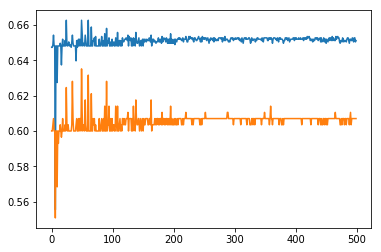

In [38]:
my_MLP.train(X, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, epochs=500,
             hidden_layer_sizes = (200,), batch_size = 100, learning_rate_init=1e-2, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 0.2, tol = 1e-4)

Weights used: {2.0: 261.4, 1.0: 1.54, 0.0: 2.87}
epoch=0 tscore=0.4139250191277735 vscore=0.3894736842105263
epoch=1 tscore=0.4429992348890589 vscore=0.4280701754385965
epoch=2 tscore=0.44376434583014535 vscore=0.43157894736842106
epoch=3 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=4 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=5 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=6 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=7 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=8 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=9 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=10 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=11 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=12 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=13 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=14 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=15 tscore=0.44529456771231

/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


epoch=45 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=46 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=47 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=48 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=49 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=50 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=51 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=52 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=53 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=54 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=55 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=56 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=57 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=58 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=59 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=60 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=61

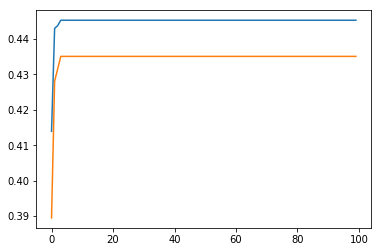

In [39]:
my_lr.train(X, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, epochs=100,
            penalty="l2", dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
            class_weight=None,  solver="newton-cg", max_iter=100, multi_class="multinomial")

In [40]:
my_forest.train(X, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, tree_type='XRF',
                n_estimators = 50, max_features = "auto", criterion = "entropy", max_depth = 15,
                min_samples_split = 50, n_jobs = -1)

tscore=0.707985 vscore=0.658451
Score on smaller part (34.51%) of validation set (unbalanced case): 0.09
Score on bigger part (65.49%) of validation set (unbalanced case): 0.96
Category histogram in validation set: {2.0: 2, 0.0: 96, 1.0: 186}


(281, 13) (281,)
0.6725978647686833
[0.67259786 0.         0.         0.        ]
1
(288, 13) (288,)
0.4340277777777778
[0.67259786 0.43402778 0.         0.        ]
2
(288, 13) (288,)
0.6666666666666666
[0.67259786 0.43402778 0.66666667 0.        ]
3
(288, 13) (288,)
0.6736111111111112
[0.67259786 0.43402778 0.66666667 0.67361111]
4


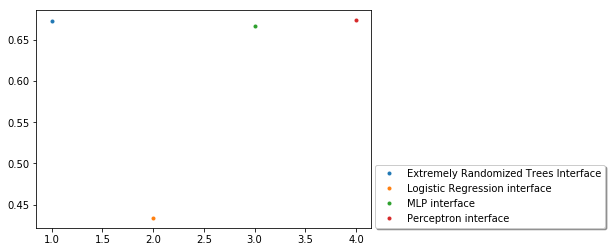

best is Perceptron interface with score 0.67


In [41]:
best = test_sup(my_forest, my_lr, my_MLP, my_perc)

In [42]:
#pay attention: MLP not weighted
num_age = best.predict(X,y, fill_up=True)

/Users/Renato/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Data Allowance

Most of the points looks like they're concentrated between 0 and 0.5. To better investigate this, let's look at the density of this column:

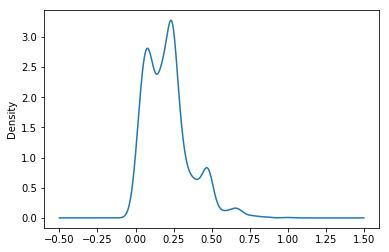

In [43]:
df_clean['DataAllowance'].plot.density()

In [44]:
mask = df_clean['DataAllowance'] > 0.5
np.sum(~mask)

1939

Therefore there are 1575 (over the 1636 not nan) which are below 0.5, so our conjecture was quite good. Given this, our idea is to take into consideration for our imputation just these X's, below 0.5, not using the outliers. We proceed using the above mask:

In [45]:
X = df_filled[traffic_columns][~mask]
df_filled['DataAllowance'] = df_filled['DataAllowance'].map(lambda x: '%.1f'%x, na_action = 'ignore')
y = df_filled['DataAllowance'][~mask]

build_seed = 4562
my_perc = perc(build_seed)
my_MLP = MLP(build_seed)
my_lr = LogReg(build_seed)

run=1 tscore=0.360958 vscore=0.351464
run=2 tscore=0.366483 vscore=0.372385
run=3 tscore=0.370166 vscore=0.389121
run=4 tscore=0.37477 vscore=0.393305
run=5 tscore=0.375691 vscore=0.389121
run=6 tscore=0.369245 vscore=0.384937
run=7 tscore=0.379374 vscore=0.384937
run=8 tscore=0.37477 vscore=0.384937
run=9 tscore=0.37477 vscore=0.393305
run=10 tscore=0.372007 vscore=0.384937
run=11 tscore=0.380295 vscore=0.384937
run=12 tscore=0.37477 vscore=0.376569
run=13 tscore=0.367403 vscore=0.393305
run=14 tscore=0.375691 vscore=0.380753
run=15 tscore=0.372928 vscore=0.384937
run=16 tscore=0.376611 vscore=0.389121
run=17 tscore=0.377532 vscore=0.380753
run=18 tscore=0.37477 vscore=0.384937
run=19 tscore=0.37477 vscore=0.389121
run=20 tscore=0.370166 vscore=0.380753
run=21 tscore=0.369245 vscore=0.384937
run=22 tscore=0.373849 vscore=0.376569
run=23 tscore=0.372007 vscore=0.380753
run=24 tscore=0.375691 vscore=0.389121
run=25 tscore=0.371087 vscore=0.384937
run=26 tscore=0.382136 vscore=0.384937
r

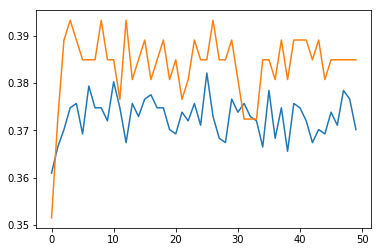

In [46]:
my_perc.train(X, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, epochs=50,  
              loss='log', penalty='none', alpha=1e-8, power_t=0.7, it_interval=100, learning_rate='invscaling', 
              eta0=1e4, class_weight=None)

epoch=0 loss=1.8053158754800716 tscore=0.07550644567219153 vscore=0.0794979079497908
epoch=1 loss=1.79263988521152 tscore=0.17679558011049723 vscore=0.20920502092050208
epoch=2 loss=1.7808944177577597 tscore=0.26243093922651933 vscore=0.28870292887029286
epoch=3 loss=1.7689749765091778 tscore=0.31952117863720075 vscore=0.3389121338912134
epoch=4 loss=1.7583137996546214 tscore=0.35174953959484345 vscore=0.36401673640167365
epoch=5 loss=1.7476879701851042 tscore=0.36187845303867405 vscore=0.3807531380753138
epoch=6 loss=1.7373771367576176 tscore=0.36279926335174956 vscore=0.3891213389121339


/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


epoch=7 loss=1.728004829746177 tscore=0.36279926335174956 vscore=0.3891213389121339
epoch=8 loss=1.7187574615384587 tscore=0.36279926335174956 vscore=0.3891213389121339
epoch=9 loss=1.7098585581726402 tscore=0.36279926335174956 vscore=0.38493723849372385
epoch=10 loss=1.701526075353084 tscore=0.36279926335174956 vscore=0.38493723849372385
epoch=11 loss=1.6934366143235107 tscore=0.36279926335174956 vscore=0.38493723849372385
epoch=12 loss=1.6858969370968084 tscore=0.36279926335174956 vscore=0.38493723849372385
epoch=13 loss=1.6786132454367413 tscore=0.36279926335174956 vscore=0.38493723849372385
epoch=14 loss=1.6716634575748437 tscore=0.36279926335174956 vscore=0.38493723849372385
epoch=15 loss=1.665381747821214 tscore=0.36279926335174956 vscore=0.38493723849372385
epoch=16 loss=1.6592962569467287 tscore=0.36279926335174956 vscore=0.38493723849372385
epoch=17 loss=1.6537461924740176 tscore=0.36279926335174956 vscore=0.38493723849372385
epoch=18 loss=1.648567738096776 tscore=0.3627992633

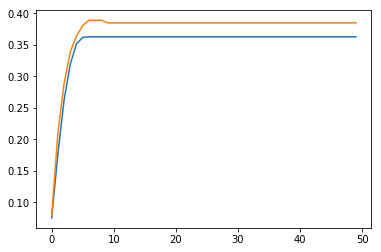

In [47]:
my_MLP.train(X, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, epochs=50,
             hidden_layer_sizes = (400,), batch_size = 100, learning_rate_init=1e-4, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 0.05, tol = 1e-4)

In [48]:
my_forest.train(X, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, tree_type='XRF',
                n_estimators = 50, max_features = "auto", criterion = "entropy", max_depth = 15,
                min_samples_split = 50, n_jobs = -1)

tscore=0.425706 vscore=0.372881


(242, 13) (242,)
0.34297520661157027
[0.34297521 0.         0.        ]
1
(250, 13) (250,)
0.372
[0.34297521 0.372      0.        ]
2
(250, 13) (250,)
0.348
[0.34297521 0.372      0.348     ]
3


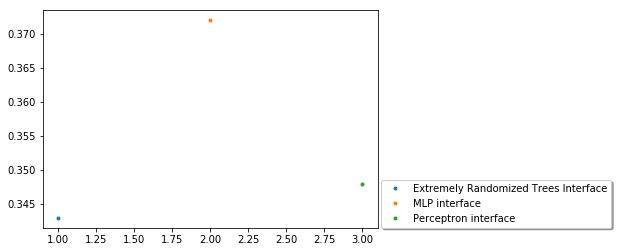

best is MLP interface with score 0.37


In [49]:
best = test_sup(my_forest, my_MLP, my_perc)

To predict, we must use the entire X and y, but with our trained MLP just on masked data.

In [50]:
X = df_filled[traffic_columns]
y = df_filled['DataAllowance']

In [51]:
data_all = best.predict(X,y, fill_up=True)

/Users/Renato/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Monthly Data Traffic

In [52]:
X = df_filled[traffic_columns]
df_filled['MonthlyDataTraffic'] = df_filled['MonthlyDataTraffic'].map(lambda x: '%.1f'%x, na_action = 'ignore')
y = df_filled['MonthlyDataTraffic']
build_seed = 4562
my_perc = perc(build_seed)
my_MLP = MLP(build_seed)
my_lr = LogReg(build_seed)

run=1 tscore=0.234043 vscore=0.252525
run=2 tscore=0.43617 vscore=0.43771
run=3 tscore=0.408815 vscore=0.420875
run=4 tscore=0.444529 vscore=0.447811
run=5 tscore=0.431611 vscore=0.430976
run=6 tscore=0.432371 vscore=0.417508
run=7 tscore=0.461246 vscore=0.47138
run=8 tscore=0.423252 vscore=0.393939
run=9 tscore=0.416413 vscore=0.40404
run=10 tscore=0.448328 vscore=0.430976
run=11 tscore=0.458207 vscore=0.447811
run=12 tscore=0.424012 vscore=0.424242
run=13 tscore=0.427812 vscore=0.414141
run=14 tscore=0.454407 vscore=0.444444
run=15 tscore=0.430851 vscore=0.390572
run=16 tscore=0.447568 vscore=0.430976
run=17 tscore=0.433891 vscore=0.414141
run=18 tscore=0.43541 vscore=0.417508
run=19 tscore=0.441489 vscore=0.43771
run=20 tscore=0.444529 vscore=0.441077
run=21 tscore=0.458967 vscore=0.451178
run=22 tscore=0.43921 vscore=0.430976
run=23 tscore=0.443769 vscore=0.43771
run=24 tscore=0.458207 vscore=0.444444
run=25 tscore=0.458207 vscore=0.454545
run=26 tscore=0.452888 vscore=0.454545
run

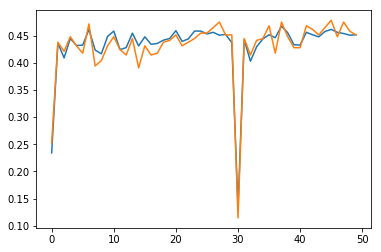

In [53]:
my_perc.train(X, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, epochs=50,  
              loss='log', penalty='none', alpha=1e-8, power_t=0.7, it_interval=100, learning_rate='invscaling', 
              eta0=1e4, class_weight={'0.2': 15.86, '0.0': 1.6, '0.1': 4.50, '0.5': 1316.0, '0.3': 101.23, '0.4': 188.0, '1.0': 658.0, '0.9': 1316.0})

epoch=0 loss=1.2721702301739526 tscore=0.6238601823708206 vscore=0.67003367003367
epoch=1 loss=0.9478191047512323 tscore=0.6246200607902735 vscore=0.6734006734006734
epoch=2 loss=0.9018776141774245 tscore=0.6246200607902735 vscore=0.6632996632996633
epoch=3 loss=0.8777136164161644 tscore=0.6246200607902735 vscore=0.6734006734006734
epoch=4 loss=0.8690873260900208 tscore=0.6231003039513677 vscore=0.6666666666666666
epoch=5 loss=0.8673941638878023 tscore=0.6291793313069909 vscore=0.6734006734006734
epoch=6 loss=0.8610961666914014 tscore=0.628419452887538 vscore=0.6801346801346801
epoch=7 loss=0.853497963973305 tscore=0.6390577507598785 vscore=0.6801346801346801
epoch=8 loss=0.854839934715213 tscore=0.6352583586626139 vscore=0.6666666666666666


/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


epoch=9 loss=0.8453416679933262 tscore=0.628419452887538 vscore=0.6734006734006734
epoch=10 loss=0.8591789924787715 tscore=0.6405775075987842 vscore=0.6734006734006734
epoch=11 loss=0.849542229679893 tscore=0.6314589665653495 vscore=0.6801346801346801
epoch=12 loss=0.8488907586639342 tscore=0.6534954407294833 vscore=0.6835016835016835
epoch=13 loss=0.8521252183775183 tscore=0.6458966565349544 vscore=0.6767676767676768
epoch=14 loss=0.8348050328459945 tscore=0.6428571428571429 vscore=0.6767676767676768
epoch=15 loss=0.8357672629027297 tscore=0.6443768996960486 vscore=0.6767676767676768
epoch=16 loss=0.8570697165458113 tscore=0.6550151975683891 vscore=0.6801346801346801
epoch=17 loss=0.8299139418359671 tscore=0.6580547112462006 vscore=0.6734006734006734
epoch=18 loss=0.8259174788326762 tscore=0.6580547112462006 vscore=0.6801346801346801
epoch=19 loss=0.8256035989987903 tscore=0.6534954407294833 vscore=0.67003367003367
epoch=20 loss=0.827213926053905 tscore=0.6534954407294833 vscore=0.680

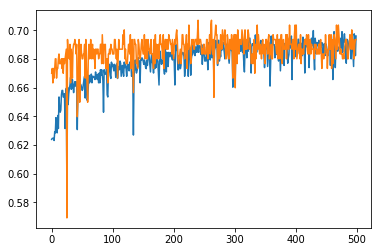

In [54]:
my_MLP.train(X, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, epochs=500,
             hidden_layer_sizes = (200,), batch_size = 100, learning_rate_init=1e-2, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 0.01, tol = 1e-4)

In [55]:
my_forest.train(X, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, tree_type='XRF',
                n_estimators = 50, max_features = "auto", criterion = "entropy", max_depth = 15,
                min_samples_split = 50, n_jobs = -1)

tscore=0.679583 vscore=0.596491
Score on smaller part (41.40%) of validation set (unbalanced case): 0.07
Score on bigger part (58.60%) of validation set (unbalanced case): 0.97
Category histogram in validation set: {'0.2': 21, '0.0': 167, '0.1': 92, '0.4': 2, '0.3': 3}


(290, 13) (290,)
0.6344827586206897
[0.63448276 0.         0.        ]
1
(304, 13) (304,)
0.625
[0.63448276 0.625      0.        ]
2
(304, 13) (304,)
0.47368421052631576
[0.63448276 0.625      0.47368421]
3


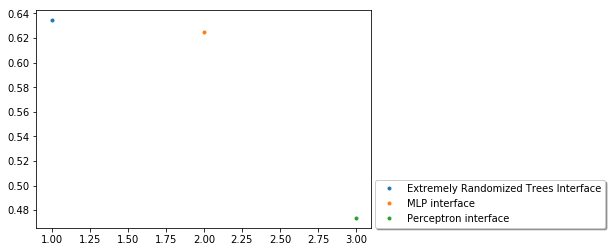

best is Extremely Randomized Trees Interface with score 0.63


In [56]:
best = test_sup(my_forest, my_MLP, my_perc)

In [57]:
data_traffic = best.predict(X,y, fill_up=True)

/Users/Renato/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Data ARPU

In [58]:
X = df_filled[traffic_columns]
df_filled['DataArpu'] = df_filled['DataArpu'].map(lambda x: '%.1f'%x, na_action = 'ignore')
y = df_filled['DataArpu']
build_seed = 4562
my_perc = perc(build_seed)
my_MLP = MLP(build_seed)
my_lr = LogReg(build_seed)

run=1 tscore=0.339476 vscore=0.295154
run=2 tscore=0.445199 vscore=0.422907
run=3 tscore=0.451018 vscore=0.45815
run=4 tscore=0.448109 vscore=0.427313
run=5 tscore=0.451988 vscore=0.449339
run=6 tscore=0.453928 vscore=0.45815
run=7 tscore=0.452958 vscore=0.449339
run=8 tscore=0.450048 vscore=0.436123
run=9 tscore=0.448109 vscore=0.444934
run=10 tscore=0.451018 vscore=0.440529
run=11 tscore=0.451988 vscore=0.449339
run=12 tscore=0.449079 vscore=0.427313
run=13 tscore=0.451018 vscore=0.431718
run=14 tscore=0.452958 vscore=0.436123
run=15 tscore=0.454898 vscore=0.431718
run=16 tscore=0.452958 vscore=0.449339
run=17 tscore=0.451988 vscore=0.453744
run=18 tscore=0.450048 vscore=0.440529
run=19 tscore=0.454898 vscore=0.436123
run=20 tscore=0.452958 vscore=0.449339
run=21 tscore=0.454898 vscore=0.444934
run=22 tscore=0.451018 vscore=0.449339
run=23 tscore=0.452958 vscore=0.444934
run=24 tscore=0.451018 vscore=0.440529
run=25 tscore=0.453928 vscore=0.444934
run=26 tscore=0.451988 vscore=0.4449

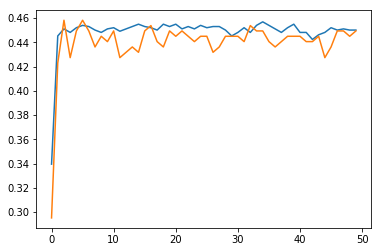

In [59]:
my_perc.train(X, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, epochs=50,  
              loss='log', penalty='none', alpha=1e-8, power_t=0.7, it_interval=100, learning_rate='invscaling', 
              eta0=1e4, class_weight=None)

epoch=0 loss=1.5733134284056978 tscore=0.35208535402521823 vscore=0.31718061674008813
epoch=1 loss=1.3368616431840834 tscore=0.45004849660523766 vscore=0.4713656387665198
epoch=2 loss=1.324970674299639 tscore=0.45004849660523766 vscore=0.46255506607929514
epoch=3 loss=1.3221796895882019 tscore=0.45489815712900095 vscore=0.4669603524229075
epoch=4 loss=1.3226513995760634 tscore=0.45489815712900095 vscore=0.4669603524229075
epoch=5 loss=1.3226663537313756 tscore=0.45586808923375366 vscore=0.4669603524229075
epoch=6 loss=1.3160300102117184 tscore=0.45004849660523766 vscore=0.42731277533039647
epoch=7 loss=1.3297636044129002 tscore=0.451988360814743 vscore=0.43171806167400884


/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


epoch=8 loss=1.3318164118391718 tscore=0.46071774975751695 vscore=0.45374449339207046
epoch=9 loss=1.3182152830225085 tscore=0.4481086323957323 vscore=0.42731277533039647
epoch=10 loss=1.3106562281418765 tscore=0.46071774975751695 vscore=0.45374449339207046
epoch=11 loss=1.315013782454274 tscore=0.457807953443259 vscore=0.4581497797356828
epoch=12 loss=1.3124552078020988 tscore=0.45489815712900095 vscore=0.44493392070484583
epoch=13 loss=1.3021438198737412 tscore=0.457807953443259 vscore=0.46255506607929514
epoch=14 loss=1.312502868000196 tscore=0.4597478176527643 vscore=0.4185022026431718
epoch=15 loss=1.3086960178726077 tscore=0.45877788554801163 vscore=0.4581497797356828
epoch=16 loss=1.311071514440176 tscore=0.4568380213385063 vscore=0.4581497797356828
epoch=17 loss=1.306688512419762 tscore=0.45295829291949563 vscore=0.43171806167400884
epoch=18 loss=1.2985884591241053 tscore=0.4539282250242483 vscore=0.42290748898678415
epoch=19 loss=1.3044139808010011 tscore=0.4568380213385063 vs

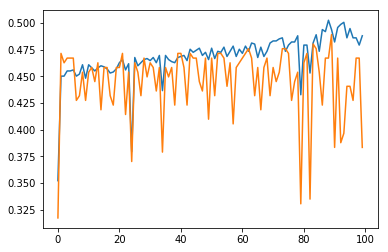

In [60]:
my_MLP.train(X, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, epochs=100,
             hidden_layer_sizes = (200,50), batch_size = 100, learning_rate_init=1e-2, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 0.01, tol = 1e-4)

In [61]:
my_forest.train(X, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, tree_type='XRF',
                n_estimators = 50, max_features = "auto", criterion = "entropy", max_depth = 15,
                min_samples_split = 50, n_jobs = -1)

tscore=0.544928 vscore=0.497758


(235, 13) (235,)
0.4851063829787234
[0.48510638 0.         0.        ]
1
(235, 13) (235,)
0.4425531914893617
[0.48510638 0.44255319 0.        ]
2
(235, 13) (235,)
0.41702127659574467
[0.48510638 0.44255319 0.41702128]
3


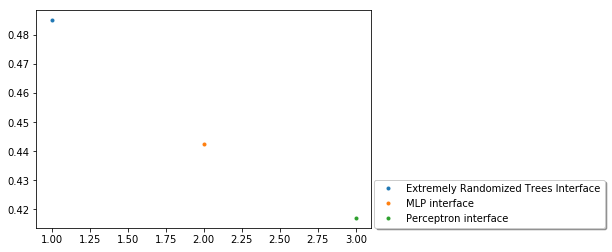

best is Extremely Randomized Trees Interface with score 0.49


In [62]:
test_sup(my_forest, my_MLP, my_perc)

In [63]:
data_arpu = best.predict(X,y, fill_up=True)

/Users/Renato/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Monthly Voice Traffic Count

In [64]:
X = df_filled[traffic_columns]
df_filled['MonthlyVoiceTrafficCount'] = df_filled['MonthlyVoiceTrafficCount'].map(lambda x: '%.1f'%x, na_action = 'ignore')
y = df_filled['MonthlyVoiceTrafficCount']
build_seed = 4562
my_perc = perc(build_seed)
my_MLP = MLP(build_seed)
my_lr = LogReg(build_seed)

run=1 tscore=0.31383 vscore=0.333333
run=2 tscore=0.462006 vscore=0.488215
run=3 tscore=0.474164 vscore=0.498316
run=4 tscore=0.448328 vscore=0.47138
run=5 tscore=0.466565 vscore=0.474747
run=6 tscore=0.462766 vscore=0.481481
run=7 tscore=0.468085 vscore=0.47138
run=8 tscore=0.447568 vscore=0.468013
run=9 tscore=0.458967 vscore=0.481481
run=10 tscore=0.471884 vscore=0.498316
run=11 tscore=0.469605 vscore=0.498316
run=12 tscore=0.447568 vscore=0.47138
run=13 tscore=0.448328 vscore=0.47138
run=14 tscore=0.466565 vscore=0.501684
run=15 tscore=0.469605 vscore=0.494949
run=16 tscore=0.458207 vscore=0.478114
run=17 tscore=0.464286 vscore=0.488215
run=18 tscore=0.464286 vscore=0.464646
run=19 tscore=0.478723 vscore=0.491582
run=20 tscore=0.471884 vscore=0.491582
run=21 tscore=0.463526 vscore=0.484848
run=22 tscore=0.464286 vscore=0.488215
run=23 tscore=0.453647 vscore=0.484848
run=24 tscore=0.458207 vscore=0.481481
run=25 tscore=0.480243 vscore=0.501684
run=26 tscore=0.478723 vscore=0.501684


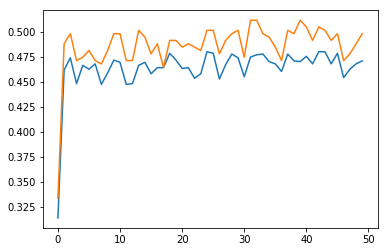

In [65]:
my_perc.train(X, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, epochs=50,  
              loss='log', penalty='none', alpha=1e-8, power_t=0.7, it_interval=100, learning_rate='invscaling', 
              eta0=1e4, class_weight=None)

epoch=0 loss=1.462729973580239 tscore=0.44756838905775076 vscore=0.45791245791245794
epoch=1 loss=1.2945708379045064 tscore=0.44756838905775076 vscore=0.4612794612794613
epoch=2 loss=1.2792098171893922 tscore=0.4870820668693009 vscore=0.5151515151515151
epoch=3 loss=1.2705528992235313 tscore=0.4582066869300912 vscore=0.47474747474747475
epoch=4 loss=1.2657740823141965 tscore=0.4688449848024316 vscore=0.48148148148148145
epoch=5 loss=1.254091497675964 tscore=0.49240121580547114 vscore=0.5084175084175084


/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


epoch=6 loss=1.2499368665671144 tscore=0.4848024316109423 vscore=0.48484848484848486
epoch=7 loss=1.2571265882488716 tscore=0.4688449848024316 vscore=0.45791245791245794
epoch=8 loss=1.2528858376275442 tscore=0.4673252279635258 vscore=0.45791245791245794
epoch=9 loss=1.2709898054989057 tscore=0.45972644376899696 vscore=0.47474747474747475
epoch=10 loss=1.2595100072661976 tscore=0.49772036474164133 vscore=0.5050505050505051
epoch=11 loss=1.2396118353043006 tscore=0.49620060790273557 vscore=0.494949494949495
epoch=12 loss=1.2343629585799207 tscore=0.4946808510638298 vscore=0.5016835016835017
epoch=13 loss=1.2405325405946528 tscore=0.49772036474164133 vscore=0.5084175084175084
epoch=14 loss=1.2510180247356397 tscore=0.4969604863221885 vscore=0.4983164983164983
epoch=15 loss=1.2354128683897727 tscore=0.4939209726443769 vscore=0.4983164983164983
epoch=16 loss=1.2345330040493474 tscore=0.5 vscore=0.5050505050505051
epoch=17 loss=1.2259530336012263 tscore=0.49848024316109424 vscore=0.50168350

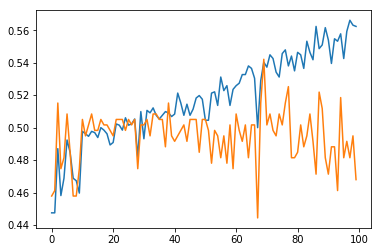

In [66]:
my_MLP.train(X, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, epochs=100,
             hidden_layer_sizes = (200,50), batch_size = 100, learning_rate_init=1e-2, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 0.01, tol = 1e-4)

In [67]:
my_forest.train(X, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, tree_type='XRF',
                n_estimators = 50, max_features = "auto", criterion = "entropy", max_depth = 15,
                min_samples_split = 50, n_jobs = -1)

tscore=0.535768 vscore=0.477193


(290, 13) (290,)
0.4586206896551724
[0.45862069 0.         0.        ]
1
(304, 13) (304,)
0.41118421052631576
[0.45862069 0.41118421 0.        ]
2
(304, 13) (304,)
0.4276315789473684
[0.45862069 0.41118421 0.42763158]
3


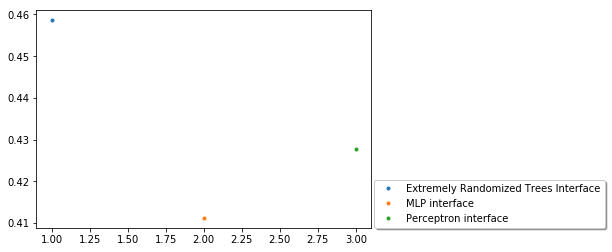

best is Extremely Randomized Trees Interface with score 0.46


In [68]:
best = test_sup(my_forest, my_MLP, my_perc)

In [69]:
voice_traffic_c = best.predict(X,y, fill_up=True)

/Users/Renato/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [70]:
df_good = df_filled.copy()
col_to_del = ['CustomerAge', 'DevicePrice', 'Province', 'Region', 'ZipCode', 'DeviceOperatingSystem']
df_good.drop(col_to_del, axis=1, inplace=True)
df_good['MonthlySmsTrafficCount'][df_good['MonthlySmsTrafficCount'].isnull()] = df_good['MonthlySmsTrafficCount'].mean()
df_good.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 27 columns):
ID                                2000 non-null int64
Product                           2000 non-null object
DataAllowance                     2000 non-null object
DataArpu                          2000 non-null object
DeviceFlag4G                      2000 non-null float64
DeviceFlagSmartphone              2000 non-null float64
MonthlyDataTraffic                2000 non-null object
MonthlyVoiceTrafficCount          2000 non-null object
CustomerGender                    2000 non-null float64
CustomerImmigrant                 2000 non-null float64
MonthlySmsTrafficCount            2000 non-null float64
File-Transfer                     2000 non-null float64
Games                             2000 non-null float64
Instant-Messaging-Applications    2000 non-null float64
Mail                              2000 non-null float64
Music-Streaming                   2000 non-null float64
Netw

/Users/Renato/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [71]:
df_final = df_good.copy()

# Clustering

In [455]:
class GridSearch():
    def __init__(self, seed = None, build_seed = None, **args):
        if seed is None:
            seed = np.random.randint(666766)
        self.seed = seed
        self.build_seed = build_seed
         
    def get_best(self, X, y, obj, percentage=(0.8,0.1,0.1), std=False, pca=False, one_hot=False, cat_col=None, epochs=5, 
                 wmin=0, wmax=1, weights=None, start_config=None, data=None):
        if data is None:
            data = buildTrain(X, y, percentage, std, pca, self.build_seed, one_hot, cat_col)
        
        train = data.get_train()[0]
        n_features = train.shape[1]
           
        if weights is None:
            mid_val = (wmin+wmax)/2
            weights = np.array([wmin, mid_val, wmax])
        if start_config is None:
            best_config = np.ones(n_features)
        else:
            best_config = start_config
            
        scores = [0]
        c = 0
        s_time = time.time()
        for feature in np.random.randint(n_features, size=epochs*n_features):
            best_score = 0
            for weight in weights:
                if c %10000 == 0:
                    print(c)
                c += 1
                config = best_config.copy()
                config[feature] = weight
                temp = np.eye(n_features)*config
                X_train_mod = np.dot(train, temp)
                X_valid_mod = np.dot(data.get_valid()[0], temp)
                obj.fit(X_train_mod, data.get_train()[1])
                score = obj.score(X_valid_mod, data.get_valid()[1])
                if score > best_score:
                    scores.append(score)
                    best_score = score
                    best_config[feature] = weight
        print('elapsed time:', time.time()-s_time)
        plt.figure()
        plt.plot(np.arange(len(scores)), scores)
        return best_config, best_score
    
    def score(self, pred_labels, true_labels):
        return metrics.homogeneity_score(pred_labels, true_labels)       

## Find weights with KNN

In [539]:
df = df_good.copy()
col = df.columns[2:]

d_map = {'iOS': 1, 'Android': 2, 'other': 3}
df['OS_clean'] = df['OS_clean'].map(d_map, na_action='ignore')
cat_map = {'V-Bag': 1, 'V-Auto': 2, 'V-Pet': 3, 'V-Camera': 4}
df['Product'] = df['Product'].map(cat_map, na_action='ignore')

cat_col = [i for i in col if i not in traffic_columns]
non_cat_col = [i for i in col if i not in cat_col]
cat_col.pop(cat_col.index('MonthlySmsTrafficCount'))

X = df[col]
y = df['Product']
data = buildTrain(X, y,  perc=(0.3,0.2,0.5), std=False, pca=0, seed=None, one_hot=True, cat_col=cat_col)

knn1 = KNeighborsClassifier(n_neighbors=4)
weights = np.linspace(0, 10.0, num = 70)

grid = GridSearch(build_seed=647645)

#grid.get_best(X, y, knn1, percentage=(0.3,0.2,0.5), std=False, pca=0, one_hot=True, cat_col=cat_col, epochs=1, 
                 #wmin=0, wmax=1, weights=None, start_config=None, data=data)

In [540]:
optimal_weights = np.array([0, 0, 0, 0.86956522, 0, 7.53623188, 0, 0, 6.08695652, 0,
        0, 2.89855072, 0.43478261, 0.43478261, 1.01449275, 1.01449275, 1.01449275, 1.01449275, 1.01449275, 1.88405797,
        0, 1.88405797, 0.28985507, 0, 0, 2.02898551, 0.72463768, 1.01449275, 0.14492754, 1.88405797,
        0, 0, 0, 0, 0, 1.15942029, 1.01449275, 0.28985507, 1.01449275, 1.01449275,
        1.01449275, 1.15942029, 1.01449275, 0, 0, 0, 0, 0, 1.01449275, 1.01449275,
        2.17391304, 0.43478261, 0.86956522, 0.86956522, 0, 0.57971014, 0, 1.30434783, 1.01449275, 2.17391304, 0, 0.72463768, 
        1.01449275, 2.17391304, 1.01449275, 1.01449275, 0, 0.86956522, 1.01449275, 1.01449275])

train = data.get_train()[0]
mask = optimal_weights>0

# Random analysis

In [541]:
X_one_hot = data.get_one_hot().loc[:, mask]
temp = np.eye(X_one_hot.shape[1]) * optimal_weights[mask]

X_mod = pd.DataFrame(np.dot(X_one_hot, temp))
data = buildTrain(X_mod, y, perc=(0.8,0.2,0), std=False, pca=False, seed = 222253)
for k in range(2, 8):
    km = KMeans(n_clusters=k)
    km.fit(*data.get_train())
    
    print(('\n ****** kmeans: %i ******' % k))
    print('\n',k, km.score(*data.get_valid()), metrics.v_measure_score(data.get_train()[1], l))
    for cl in range(k):
        l = km.labels_
        #print('k-means',k, 'cluster', cl, 'proportion', np.sum(l == cl)/len(l))
        if np.sum(l == cl)/len(l) < 0.01:
            pass
            #print('k-means',k, 'cluster', cl)
    check_clusters(y=data.get_train()[1], clust_labels=l)

(2000, 45) (45, 45)

 ****** kmeans: 2 ******


ValueError: labels_true and labels_pred must have same size, got 1609 and 1583

In [543]:
my_knn = KNeighborsClassifier(n_neighbors=4)
my_knn.fit(*data.get_train())
my_knn.score(*data.get_valid())

0.32225063938618925

(2000, 40)
performed PCA, number of features: 4, explained variance for component:
 ['0.55', '0.23', '0.06', '0.06']

 ****** hierarchical Clustering: 2 ******

 ****** hierarchical Clustering: 3 ******

 ****** hierarchical Clustering: 4 ******

 ****** hierarchical Clustering: 5 ******

 ****** hierarchical Clustering: 6 ******

 ****** hierarchical Clustering: 7 ******


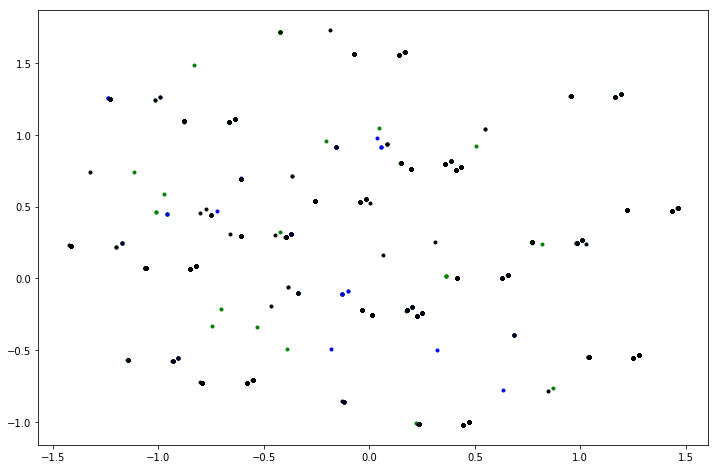

In [120]:
mask = y != 3
#X = X[mask]
#y = y[mask]
temp = np.eye(X.shape[1]) * result[0]
X_mod = pd.DataFrame(np.dot(X, temp))

data = buildTrain(X_mod, y, perc=(0.8,0.1,0.1), std=False, pca=0.9, seed = 222253)
for k in range(2, 8):
    hc = AgglomerativeClustering(n_clusters=k, linkage='complete')
    hc.fit(*data.get_train())
    #print('\n',k, km.score(*data.get_valid()), metrics.v_measure_score(data.get_train()[1], l))
    print(('\n ****** hierarchical Clustering: %i ******' % k))
    for cl in range(k):
        l = hc.labels_
        #print('k-means',k, 'cluster', cl, 'proportion', np.sum(l == cl)/len(l))
        if np.sum(l == cl)/len(l) < 0.01:
            pass
            #print('k-means',k, 'cluster', cl)
    #check_clusters(y=data.get_train()[1], clust_labels=l)

[0.32548776 0.15454095 0.12924209 0.12085372 0.11667331 0.04984239
 0.03616741] 7
[0.1230033  0.1031804  0.09020655 0.08694113 0.07741287 0.06908431
 0.06522908 0.05793124 0.05287606 0.0416408  0.03645803 0.03081396
 0.02783155 0.02192144 0.01989047] 15
[0.11445417 0.10058907 0.09576742 0.08265818 0.06921727 0.05992714
 0.05216739 0.04785174 0.04424337 0.04168855 0.03921169 0.03432303
 0.03206131 0.02989368 0.02696946 0.02243547 0.01601969] 17


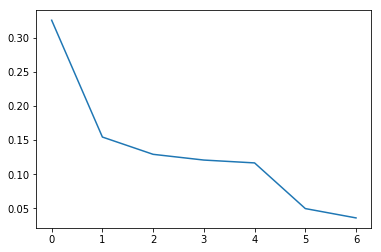

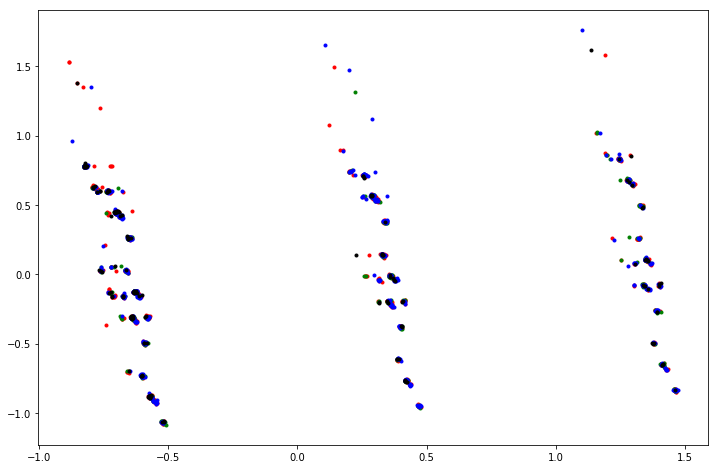

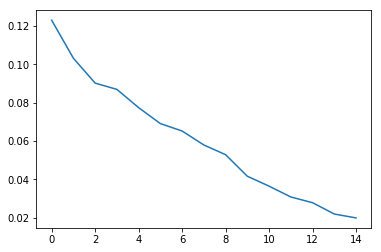

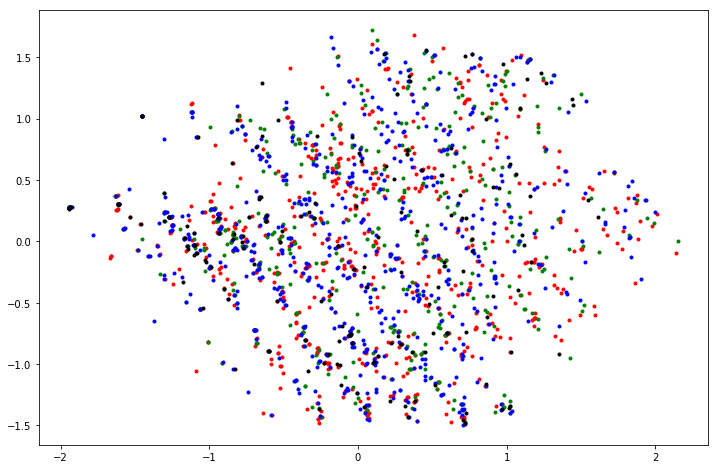

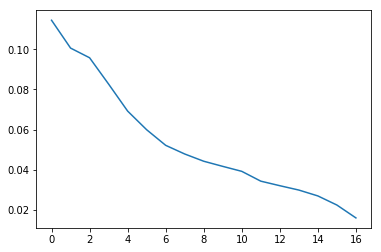

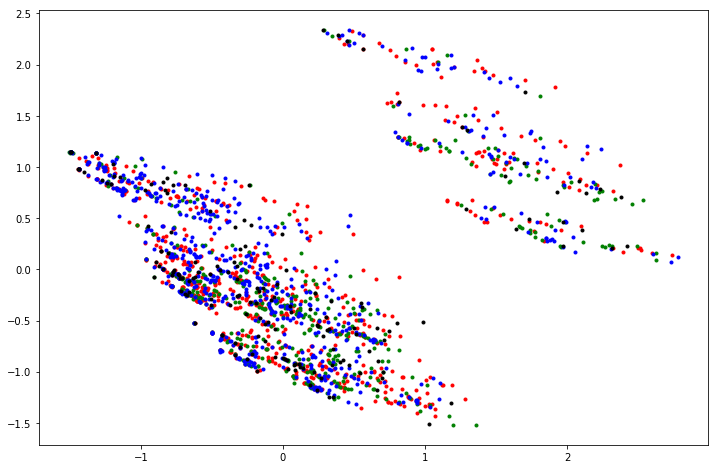

In [492]:
pca = PCA(2)
X = df[col]
y = df['Product']

one_hot = X_one_hot



xs = [df[col], one_hot, X_mod]

for X in xs:
    pca = PCA(0.9)
    x_pca = pca.fit_transform(X)
    print(pca.explained_variance_ratio_, pca.n_components_)
    plt.figure()
    plt.plot(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
    plt.figure(figsize=(12,8))
    c = ['r','g','b','black']
    cat_map = {'V-Bag': 1, 'V-Auto': 2, 'V-Pet': 3, 'V-Camera': 4}
    for i in range(1, 5):
        plt.plot(x_pca[:,0][y==i], x_pca[:,1][y==i], '.', c=c[i-1])

hierarchical on df_good, after pca

performed PCA, number of features: 2, explained variance for component:
 ['0.61', '0.29']

 ****** hierarchical Clustering: 2 ******

cluster: 0
--> top category: 1, frequency of category (variety within cluster): 36.79%, category clustering: 99.14%
Cluster size: 99.24%
--> histogram: {1: 36.79185232336092, 2: 22.533418204964992, 3: 31.95416931890516, 4: 8.720560152768938}

cluster: 1
--> top category: 1, frequency of category (variety within cluster): 41.67%, category clustering: 0.86%
Cluster size: 0.76%
--> histogram: {1: 41.66666666666667, 2: 8.333333333333332, 3: 33.33333333333333, 4: 16.666666666666664}
Overall score (doesn't consider category clustering): 39.23%, weighted: 36.83%

 ****** hierarchical Clustering: 3 ******

cluster: 0
--> top category: 1, frequency of category (variety within cluster): 38.37%, category clustering: 49.23%
Cluster size: 47.25%
--> histogram: {1: 38.36898395721925, 2: 22.593582887700535, 3: 31.417112299465238, 4: 7.620320855614973}

cluster: 1
--> t

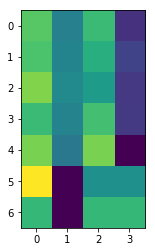

In [493]:
pca = PCA(2)
X = df[col]
y = df['Product']
#x_pca = pca.fit_transform(X)
data = buildTrain(X, y, perc=(0.8,0.1,0.1), std=False, pca=2, seed = 2253)
for k in range(2, 8):
    hc = AgglomerativeClustering(n_clusters=k, linkage='average')
    hc.fit(*data.get_train())
    #print('\n',k, km.score(*data.get_valid()), metrics.v_measure_score(data.get_train()[1], l))
    print(('\n ****** hierarchical Clustering: %i ******' % k))
    for cl in range(k):
        l = hc.labels_
        #print('k-means',k, 'cluster', cl, 'proportion', np.sum(l == cl)/len(l))
        if np.sum(l == cl)/len(l) < 0.01:
            pass
            #print('k-means',k, 'cluster', cl)
    check_clusters(y=data.get_train()[1], clust_labels=l)

decision tree on one_hot df_good

In [537]:
X = df[col]
y = df['Product']
data = buildTrain(X, y,  perc=(0.3,0.2,0.5), std=False, pca=0, seed=None, one_hot=True, cat_col=cat_col)

my_forest = trees(build_seed=23456, data=data)

my_forest.train(one_hot, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, tree_type='DT',
                max_depth=4)
#my_forest.view_tree(feature_names=feature_names)
#my_forest.train('sfdg', y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, tree_type='XRF',
                #n_estimators = 100, max_features = 'auto', criterion = 'entropy', max_depth=5, min_samples_split = 50, n_jobs = -1)

tscore=0.4608 vscore=0.344221


In [498]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 27 columns):
ID                                2000 non-null int64
Product                           2000 non-null int64
DataAllowance                     2000 non-null object
DataArpu                          2000 non-null object
DeviceFlag4G                      2000 non-null float64
DeviceFlagSmartphone              2000 non-null float64
MonthlyDataTraffic                2000 non-null object
MonthlyVoiceTrafficCount          2000 non-null object
CustomerGender                    2000 non-null float64
CustomerImmigrant                 2000 non-null float64
MonthlySmsTrafficCount            2000 non-null float64
File-Transfer                     2000 non-null float64
Games                             2000 non-null float64
Instant-Messaging-Applications    2000 non-null float64
Mail                              2000 non-null float64
Music-Streaming                   2000 non-null float64
Netwo